In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import warnings

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

sys.path.append("../../..")
from batchflow import *
from batchflow.opensets import MNIST
from batchflow.models.eager_torch import EagerTorch
from batchflow.models.eager_torch.layers import ConvBlock

# Set GPU
# %env CUDA_VISIBLE_DEVICES=6

In [2]:
inputs = 2*np.ones((6, 3, 28, 28), dtype=np.float32)
inputs = torch.from_numpy(inputs)
tuple(inputs.shape)

(6, 3, 28, 28)

In [3]:
s = ConvBlock(inputs=inputs, layout='Rca.ccav', filters=[6, 12, 18], activation='sigmoid')

In [4]:
s

ConvBlock(
  (block_modules): ModuleList(
    (0): Sequential(
      (Layer 1, letter "c"; (None, 3, 28, 28) -> (None, 6, 28, 28)): Conv(
        (layer): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
      )
      (Layer 2, letter "a"; (None, 6, 28, 28) -> (None, 6, 28, 28)): Activation(
        (activation): Sigmoid()
      )
    )
    (1): Sequential(
      (Layer 4, letter "c"; (None, 9, 28, 28) -> (None, 12, 28, 28)): Conv(
        (layer): Conv2d(9, 12, kernel_size=(3, 3), stride=(1, 1))
      )
      (Layer 5, letter "c"; (None, 12, 28, 28) -> (None, 18, 28, 28)): Conv(
        (layer): Conv2d(12, 18, kernel_size=(3, 3), stride=(1, 1))
      )
      (Layer 6, letter "a"; (None, 18, 28, 28) -> (None, 18, 28, 28)): Activation(
        (activation): Sigmoid()
      )
      (Layer 7, letter "v"; (None, 18, 28, 28) -> (None, 18, 14, 14)): Pool(
        (layer): AvgPool(
          (layer): AvgPool2d(kernel_size=2, stride=2, padding=0)
        )
      )
    )
  )
  (skip_modules): Mo

# Setup

In [5]:
mnist = MNIST(batch_class=ImagesBatch)

if __name__ == '__main__':
    MICROBATCH = None
    DEVICE = None

print('\nMicrobatching is: {}'.format(MICROBATCH))
print('\nDevice is: {}'.format(DEVICE))    


Microbatching is: None

Device is: None


In [6]:
IMAGE_SHAPE = (1, 28, 28)

def get_classification_config(model_class, config):
    default_config = {
#         'inputs/images/shape': IMAGE_SHAPE,
#         'inputs/labels/classes': 10,
#         'initial_block/inputs': 'images',
        'loss': 'ce',
        'microbatch': MICROBATCH,
        'device': DEVICE,
    }

    pipeline_config = {
        'model': model_class,
        'model_config': {**default_config, **config},
        'feed_dict': {'images': B('images'),
                      'labels': B('labels')},
    }
    return pipeline_config

def get_segmentation_config(model_class, config):
    default_config = {
        'inputs/images/shape': IMAGE_SHAPE,
        'inputs/masks/shape': IMAGE_SHAPE,
        'initial_block/inputs': 'images',
        'body/decoder/blocks/combine_op': 'concat', # for some reason `concat` is not working from within pytest 
        'loss': 'mse',
        'microbatch': MICROBATCH,
        'device': DEVICE,
    }
    
    pipeline_config = {
        'model': model_class,
        'model_config': {**default_config, **config},
        'feed_dict': {'images': B('images'),
                      'masks': B('images')},
    }
    return pipeline_config

In [7]:
def get_pipeline(pipeline_config):
    """ Pipeline config must contain 'model', 'model_config', 'feed_dict' keys. """
    vals = pipeline_config['feed_dict'].values()

    pipeline = (Pipeline(config=pipeline_config)
                .init_variable('loss_history', [])
#                 .multiply(multiplier=1/255., preserve_type=False)
                .to_array(channels='first', dtype='float32')
                .init_model('dynamic', C('model'),
                            'MODEL', config=C('model_config'))
                .train_model('MODEL', *vals,
                             fetches='loss',
                             save_to=V('loss_history', mode='a'))
                )
    return pipeline

In [8]:
def run(task, model_class, config, description, batch_size=16, n_iters=10):
    if task.startswith('c'):
        pipeline_config = get_classification_config(model_class, config)
    elif task.startswith('s'):
        pipeline_config = get_segmentation_config(model_class, config)
        
    train_pipeline = get_pipeline(pipeline_config) << mnist.train
    _ = train_pipeline.run(batch_size, n_iters=n_iters, bar=True,
                           bar_desc=W(V('loss_history')[-1].format('Loss is {:7.7}')))
    
    print('{} {} is done'.format(task, description))
    return train_pipeline

# Classification

In [9]:
config = {
#     'inputs/images/shape': IMAGE_SHAPE,
#     'inputs/labels/classes': 10,
#     'initial_block/inputs': 'images',
    'loss': ['ce', 'ce'],
    'decay': 'exp',
    'n_iters': 25,
    'train_steps': {'a': {}, 'b': {}},
    'initial_block': {'layout': 'fafaf', 'units': [128, 256, 10]},
    'order': ['initial_block', ('ib_2', 'initial_block', EagerTorch.initial_block)],
}


ppl = run('classification', EagerTorch, config, 'simple fc', n_iters=99, batch_size=64)

Loss is 2.143291:   6%|▌         | 6/99 [00:00<00:03, 25.07it/s]

_BUILD IN TRAIN


Loss is 0.6862236: 100%|██████████| 99/99 [00:02<00:00, 41.65it/s]

classification simple fc is done


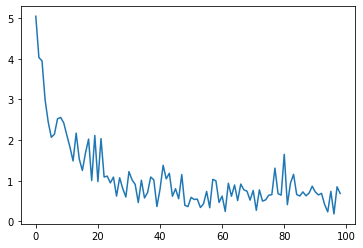

In [10]:
plt.plot(ppl.v('loss_history'))

In [11]:
ppl.get_model_by_name('MODEL').devices

[]

In [12]:
ppl.get_model_by_name('MODEL').full_config['train_steps']

{'a': {'loss': ['ce', 'ce'],
  'optimizer': ('Adam', {}),
  'decay': 'exp',
  'n_iters': 25},
 'b': {'loss': ['ce', 'ce'],
  'optimizer': ('Adam', {}),
  'decay': 'exp',
  'n_iters': 25}}

In [13]:
ppl.get_model_by_name('MODEL').train_steps

{'a': {'loss': [CrossEntropyLoss(), CrossEntropyLoss()], 'optimizer': Adam (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      eps: 1e-08
      initial_lr: 0.001
      lr: 0.0008847359999999999
      weight_decay: 0
  ), 'decay': <torch.optim.lr_scheduler.ExponentialLR at 0x7f8bffe8f6a0>, 'n_iters': 25, 'current_iter': 24},
 'b': {'loss': [CrossEntropyLoss(), CrossEntropyLoss()], 'optimizer': Adam (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      eps: 1e-08
      initial_lr: 0.001
      lr: 0.0008847359999999999
      weight_decay: 0
  ), 'decay': <torch.optim.lr_scheduler.ExponentialLR at 0x7f8bffe8f240>, 'n_iters': 25, 'current_iter': 24}}

In [14]:

config = {
    'initial_block': {'layout': 'Rcna. p cnap',
                      'filters': [16, 32], 'scale_factor': 2,},
#     'body': {'layout': 'fa'*2,
#              'units': [256, 10]},
    'head': {'layout': 'Dnfaf',
             'units': [600,10], 'dropout_rate': 0.3},
}

ppl = run('classification', EagerTorch, config, 'simple fc', n_iters=50, batch_size=64)

Loss is 2.321985:   2%|▏         | 1/50 [00:00<00:08,  5.56it/s]

_BUILD IN TRAIN


Loss is 0.4035181: 100%|██████████| 50/50 [00:04<00:00, 11.95it/s]

classification simple fc is done


In [15]:
test_pipeline = (mnist.test.p
                .import_model('MODEL', ppl)
                .init_variable('predictions')
                .init_variable('metrics', init_on_each_run=None) 
                .to_array(channels='first', dtype='float32')
                .predict_model('MODEL', B.images,
                               fetches='predictions', save_to=V('predictions'))
                .gather_metrics('class', targets=B.labels, predictions=V('predictions'),
                                fmt='logits', axis=-1, save_to=V('metrics', mode='w'))
                .run(64, shuffle=True, n_epochs=1, drop_last=False, bar=True)
)

100%|██████████| 157/157 [00:03<00:00, 41.85it/s]


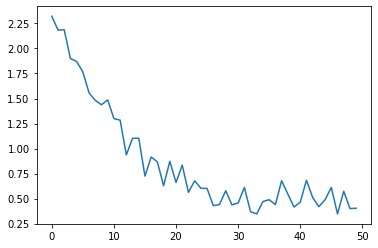

In [16]:
plt.plot(ppl.v('loss_history'))

In [17]:
metrics = test_pipeline.get_variable('metrics')
metrics.evaluate('accuracy')

0.875

In [18]:
ppl.get_model_by_name('MODEL').model

Sequential(
  (initial_block): ConvBlock(
    (block_modules): ModuleList(
      (0): Sequential(
        (Layer 1, letter "c"; (None, 1, 28, 28) -> (None, 16, 28, 28)): Conv(
          (layer): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
        )
        (Layer 2, letter "n"; (None, 16, 28, 28) -> (None, 16, 28, 28)): BatchNorm(
          (layer): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (Layer 3, letter "a"; (None, 16, 28, 28) -> (None, 16, 28, 28)): Activation(
          (activation): ReLU(inplace=True)
        )
      )
      (1): Sequential(
        (Layer 5, letter "p"; (None, 17, 28, 28) -> (None, 17, 14, 14)): Pool(
          (layer): MaxPool(
            (layer): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          )
        )
        (Layer 6, letter "c"; (None, 17, 14, 14) -> (None, 32, 14, 14)): Conv(
          (layer): Conv2d(17, 32, kernel_size=(3, 3), stride=(1, 1))
        )
 

# Segmentation

In [19]:
# config = {
#     'initial_block/filters': 4,
#     'body/encoder': {'num_stages': 3},
# }

config = {
    'initial_block': {
#         'layout': 'cnap AAbcna++ c',
        'layout': 'cnaRp cnaRp tna+ tna+ cnac',
        'filters': [16, 32, 32, 16, 8, 1],
        'kernel_size': [3, 3, 2, 2, 3, 3],
        'strides':     [1, 1, 2, 2, 1, 1],
        'scale_factor': 2, 'mode': 'bicubic'},
}

ppl = run('segmentation', EagerTorch, config, 'unet?', n_iters=1000, batch_size=32)

Loss is 7060.338:   0%|          | 1/1000 [00:00<01:47,  9.26it/s]

_BUILD IN BUILD


Loss is 463.3188: 100%|██████████| 1000/1000 [01:24<00:00, 12.46it/s]

segmentation unet? is done


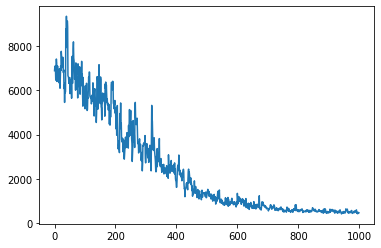

In [20]:
plt.plot(ppl.v('loss_history'))

In [21]:
ppl.get_model_by_name('MODEL').model

Sequential(
  (initial_block): ConvBlock(
    (block_modules): ModuleList(
      (0): Sequential(
        (Layer 0, letter "c"; (None, 1, 28, 28) -> (None, 16, 28, 28)): Conv(
          (layer): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
        )
        (Layer 1, letter "n"; (None, 16, 28, 28) -> (None, 16, 28, 28)): BatchNorm(
          (layer): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (Layer 2, letter "a"; (None, 16, 28, 28) -> (None, 16, 28, 28)): Activation(
          (activation): ReLU(inplace=True)
        )
      )
      (1): Sequential(
        (Layer 4, letter "p"; (None, 16, 28, 28) -> (None, 16, 14, 14)): Pool(
          (layer): MaxPool(
            (layer): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          )
        )
        (Layer 5, letter "c"; (None, 16, 14, 14) -> (None, 32, 14, 14)): Conv(
          (layer): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
        )
 